In [35]:
import numpy as np
import os
import random

import yaml

os.environ["JAX_PLATFORM_NAME"] = "cpu"
import jax.numpy as jnp
import jax
import optax
import matplotlib.pyplot as plt

seed=10
np.random.seed(seed)

def create_coordinate_set(x1, y1, x2, y2):
    if x1 == x2:
        coords = [
            (x1, i)
            for i in range(y1, y2 + (-1 if y1 > y2 else 1), -1 if y1 > y2 else 1)
        ]
    elif y1 == y2:
        coords = [
            (i, y1)
            for i in range(x1, x2 + (-1 if x1 > x2 else 1), -1 if x1 > x2 else 1)
        ]
    return np.array(coords)


def generate_random_path(grid, start, end):
    def find_path(current_position, visited):
        if current_position == end:
            return [current_position]

        possible_moves = []
        row, col = current_position
        rows, cols = grid.shape

        if row > 0 and grid[row - 1, col] == 1 and (row - 1, col) not in visited:
            possible_moves.append((-1, 0))
        if row < rows - 1 and grid[row + 1, col] == 1 and (row + 1, col) not in visited:
            possible_moves.append((1, 0))
        if col > 0 and grid[row, col - 1] == 1 and (row, col - 1) not in visited:
            possible_moves.append((0, -1))
        if col < cols - 1 and grid[row, col + 1] == 1 and (row, col + 1) not in visited:
            possible_moves.append((0, 1))

        if (
            row > 0
            and col > 0
            and grid[row - 1, col - 1] == 1
            and (row - 1, col - 1) not in visited
        ):
            possible_moves.append((-1, -1))
        if (
            row > 0
            and col < cols - 1
            and grid[row - 1, col + 1] == 1
            and (row - 1, col + 1) not in visited
        ):
            possible_moves.append((-1, 1))
        if (
            row < rows - 1
            and col > 0
            and grid[row + 1, col - 1] == 1
            and (row + 1, col - 1) not in visited
        ):
            possible_moves.append((1, -1))
        if (
            row < rows - 1
            and col < cols - 1
            and grid[row + 1, col + 1] == 1
            and (row + 1, col + 1) not in visited
        ):
            possible_moves.append((1, 1))

        if not possible_moves:
            return []

        next_move = possible_moves[np.random.choice(len(possible_moves))]
        new_position = (
            current_position[0] + next_move[0],
            current_position[1] + next_move[1],
        )
        path = find_path(new_position, visited + [current_position])

        return [current_position] + path if path is not None else None

    path = find_path(start, [])
    return np.array(path) if path is not None else None


grid_shape = (7, 7)
settingname="setting4"
expert_trajs = np.load(f"/home/guorui/jax-rl/expert_data/grid_world/{settingname}/expert_trajs.npz")
expert_trajs = [expert_trajs[name] for name in expert_trajs.files]
with open(f'/home/guorui/jax-rl/expert_data/grid_world/{settingname}.yaml') as f:
    config=yaml.safe_load(f)




start_point = tuple(expert_trajs[0][0].tolist())
end_point = tuple(expert_trajs[0][-1].tolist())

sample_trajs = []
random_path = [
    generate_random_path(np.ones(grid_shape), start_point, end_point)
    for i in range(50)
]
sample_trajs += random_path
if (0,6) !=end_point:
    random_path = [
        generate_random_path(np.ones(grid_shape), (0, 6), end_point) for i in range(20)
    ]
    sample_trajs += random_path
if (6,0) !=end_point:
    random_path = [
        generate_random_path(np.ones(grid_shape), (6, 0), end_point) for i in range(20)
    ]
    sample_trajs += random_path
if (0,0) !=end_point:
    random_path = [
        generate_random_path(np.ones(grid_shape), (0, 0), end_point) for i in range(20)
    ]
    sample_trajs += random_path
if (6,6) !=end_point:
    random_path = [
        generate_random_path(np.ones(grid_shape), (6, 6), end_point) for i in range(20)
    ]
    sample_trajs += random_path
d_0 = np.zeros(grid_shape)
d_0[start_point] = 1

d_ab = np.zeros(grid_shape)
d_ab[end_point] = 1


gamma = 0.99

beta = 0.5


def calculate_traj_distances(traj):
    r = (traj[1:] == end_point).all(axis=1) - 1

    d = np.power(gamma, np.arange(len(traj) - 1))
    d[r==0] /= (1-gamma)
    return d, r




rho_S = np.zeros((*grid_shape, *grid_shape))
rho_E = np.zeros((*grid_shape, *grid_shape))

for traj in expert_trajs:
    rho_E[traj[:-1, 0], traj[:-1:, 1], traj[1:, 0], traj[1:, 1]] += 1
for traj in sample_trajs:
    rho_S[traj[:-1, 0], traj[:-1:, 1], traj[1:, 0], traj[1:, 1]] += 1

state_ocuupy_E = np.zeros(grid_shape)
for traj in expert_trajs:
    state_ocuupy_E[traj[:-1, 0], traj[:-1, 1]] += 1


rho = (beta * rho_E + (1 - beta) * rho_S) / (
    (beta * rho_E + (1 - beta) * rho_S).sum((-1, -2))
).clip(0.1)[..., None, None]
expert_d = rho_E / rho_E.sum((-1, -2)).clip(1)[..., None, None]
expert_d[(expert_d<1)&(expert_d>0)]=0.5


# weight_e=[]
# for traj in expert_trajs:
#     weight_e.append((expert_d[traj[:-1, 0], traj[:-1:, 1]]!=0).sum((-1,-2)).prod())
# print(weight_e)
# target_E = np.concatenate(
#     [
#         (expert_d / rho)[traj[:-1, 0], traj[:-1:, 1], traj[1:, 0], traj[1:, 1]]
#         for traj in expert_trajs
#     ]
# )
# target_S = np.concatenate(
#     [
#         (expert_d / rho)[traj[:-1, 0], traj[:-1:, 1], traj[1:, 0], traj[1:, 1]]
#         for traj in sample_trajs
#     ]
# )
target_E = np.concatenate(
    [
        expert_d[traj[:-1, 0], traj[:-1:, 1], traj[1:, 0], traj[1:, 1]]
        for traj in expert_trajs
    ]
)
target_S = np.concatenate(
    [
        expert_d[traj[:-1, 0], traj[:-1:, 1], traj[1:, 0], traj[1:, 1]]
        for traj in sample_trajs
    ]
)


def get_all_data(trajs, rho):
    d_E, r_E = list(zip(*[calculate_traj_distances(traj) for traj in trajs]))
    d_E = np.concatenate(d_E)
    r_E = np.concatenate(r_E)
    rho_E = np.concatenate(
        [rho[traj[:-1, 0], traj[:-1:, 1], traj[1:, 0], traj[1:, 1]] for traj in trajs]
    )
    return rho_E, d_E, r_E


show_S = np.concatenate(
    [state_ocuupy_E[traj[:-1:, 0], traj[:-1, 1]] != 0 for traj in sample_trajs]
)
rho_E, d_E, r_E = get_all_data(expert_trajs, rho)
rho_S, d_S, r_S = get_all_data(sample_trajs, rho)

obs_E = np.concatenate([traj[:-1] for traj in expert_trajs])
obs_next_E = np.concatenate([traj[1:] for traj in expert_trajs])

obs_S = np.concatenate([traj[:-1] for traj in sample_trajs])
obs_next_S = np.concatenate([traj[1:] for traj in sample_trajs])


def calculate_y(obs, obs_next, V):
    y = gamma * V[obs_next[:, 0], obs_next[:, 1]] - V[obs[:, 0], obs[:, 1]]
    return y,  V[obs[:, 0], obs[:, 1]],V[obs_next[:, 0], obs_next[:, 1]]

def get_V(V):
    y_E, V_E, next_V_E = calculate_y(obs_E, obs_next_E, V)
    y_S, V_S, next_V_S = calculate_y(obs_S, obs_next_S, V)
    return (y_E, V_E, next_V_E), (y_S, V_S, next_V_S)

def get_Q(Q):
    Q_E = Q[obs_E[:, 0], obs_E[:, 1], obs_next_E[:, 0], obs_next_E[:, 1]]
    Q_S = Q[obs_S[:, 0], obs_S[:, 1], obs_next_S[:, 0], obs_next_S[:, 1]]
    return Q_E, Q_S


# def f_div(x):
#     return x*jnp.log(x)

# def omega_star(y):
#     return jnp.exp(y-1)

def f_div(x):
    return (x-1)**2

def omega_star(y):
    return (y / 2 + 1).clip(0)


def fp_star(y):
    return omega_star(y) * y - f_div(omega_star(y))

lamb=0.7



@jax.jit
def dualrewardV(V,Q):
    (y_E, V_E, next_V_E), (y_S, V_S, next_V_S) = get_V(V)
    Q_E, Q_S = get_Q(Q)
    return (
        (1-lamb)* (beta*(V_E*d_E).mean()+(1-beta)*(V_S*d_S).mean())   
        + lamb * (beta*(((Q_E-V_E)+0.5*(Q_E-V_E)**2).clip(0)*d_E).mean()+(1-beta)*(((Q_S-V_S)+0.5*(Q_S-V_S)**2).clip(0)*d_S).mean())   
    )

@jax.jit
def dualrewardQ(Q,V):
    (y_E, V_E, next_V_E), (y_S, V_S, next_V_S) = get_V(V)
    Q_E, Q_S = get_Q(Q)
    return (
        beta*(((Q_E-20)**2)*d_E).mean()+(1-beta)*(((Q_S-(-0.2+next_V_S))**2)*d_S).mean()
    )+((Q[...,end_point[0],end_point[1]]-20)**2).mean()*10000


def fit(V, optimizer):
    reward_V = jnp.zeros(grid_shape)
    reward_Q = jnp.zeros((*grid_shape, *grid_shape))
    alpha = jnp.zeros(1)
    opt_state = optimizer.init(V)
    reward_opt_state = optimizer.init(reward_V)
    reward_q_opt_state = optimizer.init(reward_Q)

    @jax.jit
    def reward_step(reward_V,reward_Q, opt_state):
        loss_value, grads = jax.value_and_grad(dualrewardV)(reward_V,reward_Q)
        updates, opt_state = optimizer.update(grads, opt_state, reward_V)
        reward_V = optax.apply_updates(reward_V, updates)
        return reward_V, opt_state, loss_value
    @jax.jit
    def reward_step_Q(reward_V,reward_Q, opt_state):
        loss_value, grads = jax.value_and_grad(dualrewardQ)(reward_Q,reward_V)
        updates, opt_state = optimizer.update(grads, opt_state, reward_Q)
        reward_Q = optax.apply_updates(reward_Q, updates)
        return reward_Q, opt_state, loss_value

    is_reward = 0
    for i in range(100000):
        reward_V, reward_opt_state, loss_value = reward_step(
            reward_V,reward_Q, reward_opt_state
        )
        reward_Q, reward_q_opt_state, loss_value = reward_step_Q(
            reward_V,reward_Q, reward_q_opt_state
        )
    # saveimg(reward_V,f"grid_img/test/RECOIL/reward_V.jpg")
    return reward_V,reward_Q


In [36]:


# print(res)
key = jax.random.PRNGKey(758493)  # Random seed is explicit in JAX

# V=random.uniform(key, shape=grid_shape)
V = jnp.ones(grid_shape) * 0
optimizer = optax.adam(learning_rate=1e-2)
reward_V,reward_Q = fit(V, optimizer)
cum_cost = np.zeros(grid_shape) 
cum_length = np.zeros(grid_shape) 
direction=np.zeros((*grid_shape,2)) 
for x in range(grid_shape[0]):
    for y in range(grid_shape[1]):
        if (x,y)!=end_point:
            action=rho[x,y]>0
            maxaction=np.flatnonzero(action)[np.argmax(reward_Q[x,y,action])]
            new_state=np.unravel_index(maxaction, grid_shape)
            direction[x,y]=(new_state[0]-x,new_state[1]-y)
def generate_trajectory(direction,start,end):
    state=start
    traj_set=[state]
    for i in range(50):
        if state!=end:
            new_state=tuple((state+direction[state]).tolist())
            traj_set.append(new_state)
            state=new_state
        else:
            return traj_set
    return None
    

direction=direction.astype(np.int32)
for x in range(grid_shape[0]):
    for y in range(grid_shape[1]):
        if (x,y)!=end_point:
            traj=generate_trajectory(direction,(x,y),end_point)
            if traj is None:
                cum_cost[x,y]=np.nan
                cum_length[x,y]=np.nan
            else:
                cum_cost[x,y]=len(set(map(tuple,config['unsafe_states'])).intersection(traj))
                cum_length[x,y]=len(traj)-1

In [37]:
def plotimg(data,title):
    fig, ax = plt.subplots()

    im = ax.imshow(data, cmap="gray", alpha=0.9)

    # Add a title
    ax.set_title(title)

    # Add labels to the x-axis and y-axis
    ax.set_xlabel("X-Axis")
    ax.set_ylabel("Y-Axis")

    # Add a colorbar
    fig.colorbar(im)
    for (j,i),label in np.ndenumerate(data):
        ax.text(i,j,"{:.2f}".format(label),ha='center',va='center')



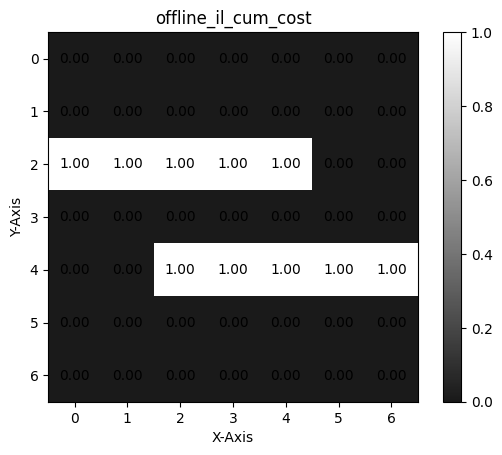

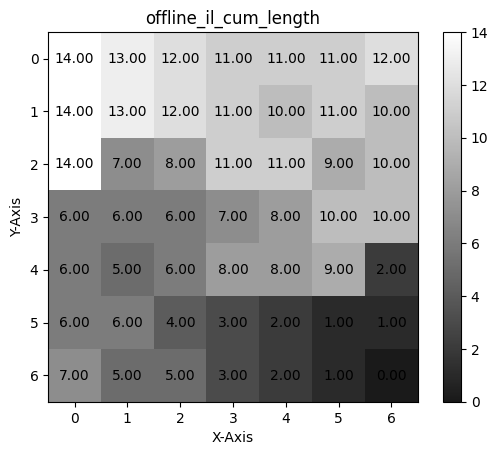

In [38]:
plotimg(cum_cost,"offline_il_cum_cost")
plotimg(cum_length,"offline_il_cum_length")
